In [1]:
# https://www.yelp.com/dataset/documentation/main

In [2]:
import json
import math
import pandas as pd
import numpy as np
import statistics
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import string
from PIL import Image
import random
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.porter import *
from sklearn import linear_model
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor

In [3]:
data_file = open("business_dataset.json")
business = []
for line in data_file:
    business.append(json.loads(line))
data_file.close()

data_file = open("100k_review_dataset.json")
reviews = []
for line in data_file:
    reviews.append(json.loads(line))
data_file.close()

data_file = open("user_dataset.json")
users = []
for line in data_file:
    users.append(json.loads(line))
data_file.close()

In [7]:
len(business),len(users),len(reviews)

(14573, 59785, 100000)

DATA CLEANING

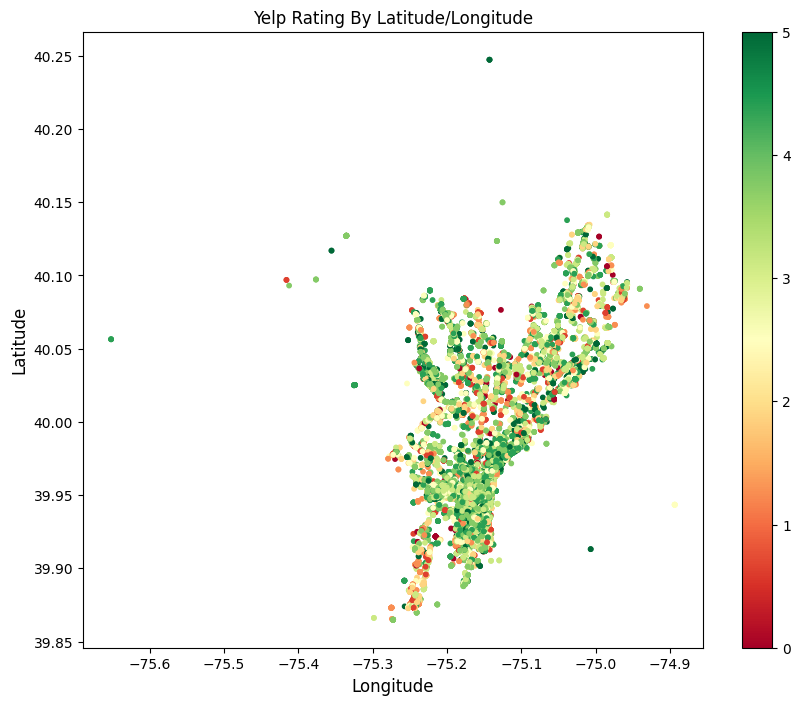

In [8]:
x = []
y = []
z = []

for d in reviews:
    idb = d['business_id']
    x.append(dataPerBusiness[idb]['longitude'])
    y.append(dataPerBusiness[idb]['latitude'])
    z.append(dataPerBusiness[idb]['stars'])
    
tars=np.random.choice([0,1,2,3,4,5], 100)
norm = plt.Normalize(np.min(tars), np.max(tars))
sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=norm)
sm.set_array([])

fig, ax = plt.subplots()
ax.scatter(x=x, y=y, c=z, cmap = 'RdYlGn', s=10)
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Yelp Rating By Latitude/Longitude')
ax.figure.colorbar(sm)
fig.set_figheight(8)
fig.set_figwidth(10)
fig.show()

In [4]:
dataPerUser = defaultdict(set)
for d in users:
    u = d['user_id']
    dataPerUser[u] = [u, d['name'], d['review_count'], d['yelping_since'], d['useful'], d['funny'], d['cool'], d['average_stars'], len(d['friends'])]   
    
dataPerBusiness = defaultdict(set)
for d in business:
    b = d['business_id']
    dataPerBusiness[b] = d

In [5]:
outliers = [d['business_id'] for d in business if d['longitude'] < -75.30 or (d['longitude'] > -75.1 and d['latitude'] < 39.95) or (d['longitude'] <- 75.1 and d['latitude'] > 40.1)]

In [6]:
newBusiness = []
for d in business:
    if d['business_id'] not in outliers:
        newBusiness.append(d)

In [7]:
len(newBusiness), len(business), len(outliers)

(14554, 14573, 19)

In [8]:
dataPerNewBusiness = defaultdict(set)
for d in newBusiness:
    b = d['business_id']
    dataPerNewBusiness[b] = d

In [9]:
newReviews = []
for d in reviews:
    if d['business_id'] in dataPerNewBusiness:
        newReviews.append(d)

In [10]:
len(newReviews)

99937

DATA EVAL

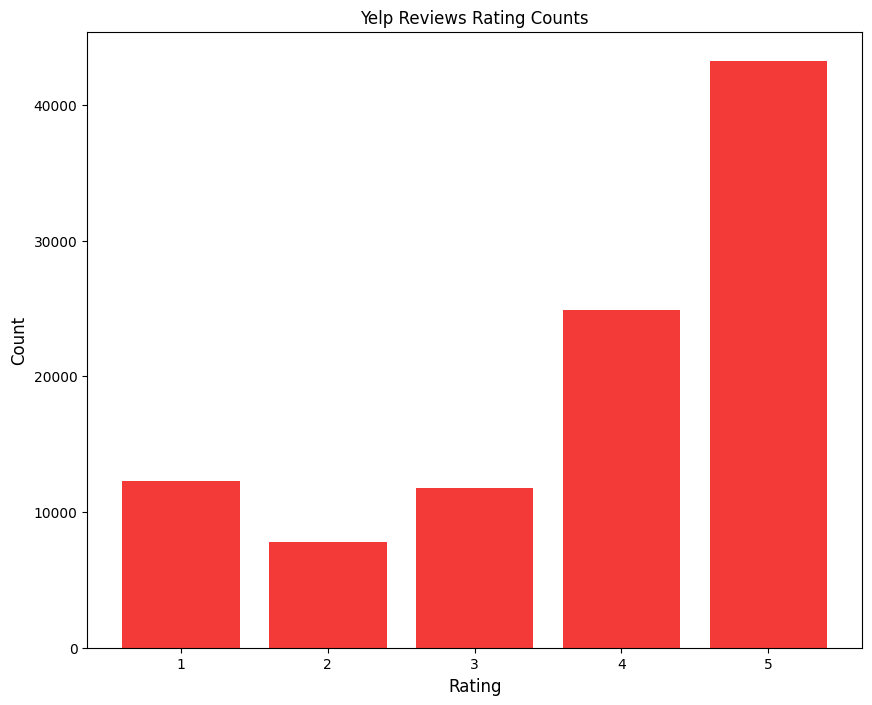

In [12]:
dist = [d['stars'] for d in reviews]
ratingCount = {}
for d in dist:
    if d in ratingCount:
        ratingCount[d] += 1
    else:
        ratingCount[d] = 1

courses = list(ratingCount.keys())
values = list(ratingCount.values())
#lb = [1,1.5,2,2.5,3,3.5,4,4.5,5]
lb = [1,2,3,4,5]

fig, ax = plt.subplots()
ax.bar(courses, values, color="#f43939")

ax.set_xticks(lb)
ax.set_xlabel('Rating', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Yelp Reviews Rating Counts')
fig.set_figheight(8)
fig.set_figwidth(10)
fig.show()

In [13]:
mean = statistics.mean(dist)
median = statistics.median(dist)
std = statistics.stdev(dist)
mean, median, std

(3.78868, 4.0, 1.3879348404126226)

In [14]:
x = [d['stars'] for d in newReviews if d['stars'] >= 4]
len(x)/len(reviews)

0.68036

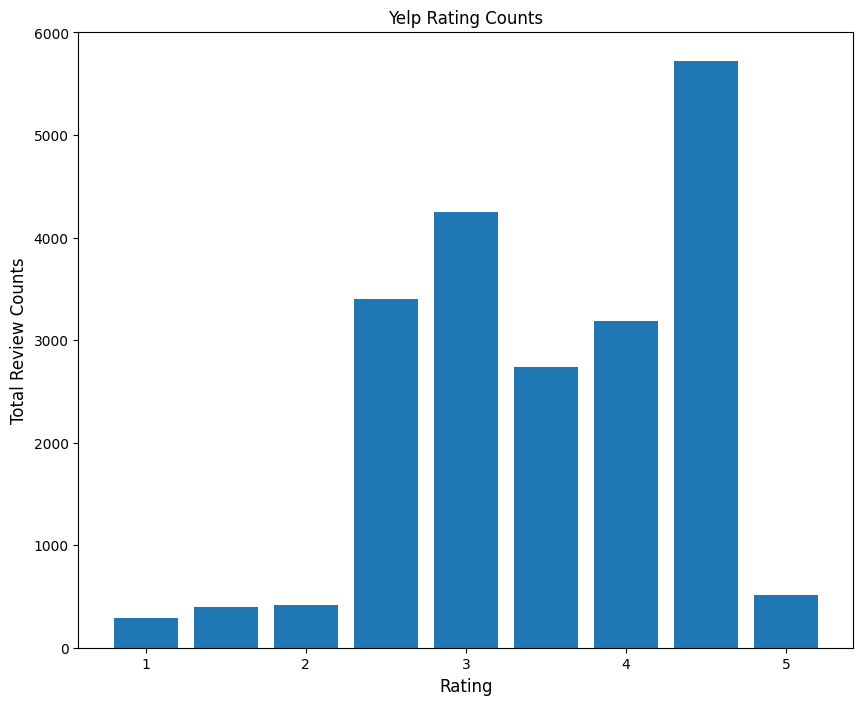

In [15]:
counts = [d['review_count'] for d in newBusiness]
x = [d['stars'] for d in newBusiness]

fig, ax = plt.subplots()
ax.bar(x, counts, width = 0.4)
ax.set_xlabel('Rating', fontsize=12)
ax.set_ylabel('Total Review Counts', fontsize=12)
ax.set_title('Yelp Rating Counts')
fig.set_figheight(8)
fig.set_figwidth(10)
fig.show()

In [12]:
categories = {}
for d in business:
    if d['categories']:
        words = d['categories'].split(',') 
        for w in words:
            sw = w.strip()
            if sw not in categories:
                categories[sw] = 1
            else:
                categories[sw] += 1

In [13]:
sortedDict = sorted(categories.items(), key=lambda x:x[1])
sortedDict.reverse()
sortedDict[200]

('Fruits & Veggies', 54)

In [14]:
topCat = sortedDict[:10] + sortedDict[200:210]

In [15]:
avgPerCat = {}
for d in topCat:
    avgPerCat[d[0]] = [0,0]

keys = avgPerCat.keys()
for d in reviews:
    idb = d['business_id']
    if dataPerBusiness[idb]['categories']:
        words = dataPerBusiness[idb]['categories'].split(',')
    
    inter = list(set(keys).intersection(words))
    for i in inter:
        avgPerCat[i][0] += d['stars']
        avgPerCat[i][1] += 1

In [16]:
for c in avgPerCat:
    avgPerCat[c] = avgPerCat[c][0] / avgPerCat[c][1]

avgPerCat = sorted(avgPerCat.items(), key=lambda x:x[1])

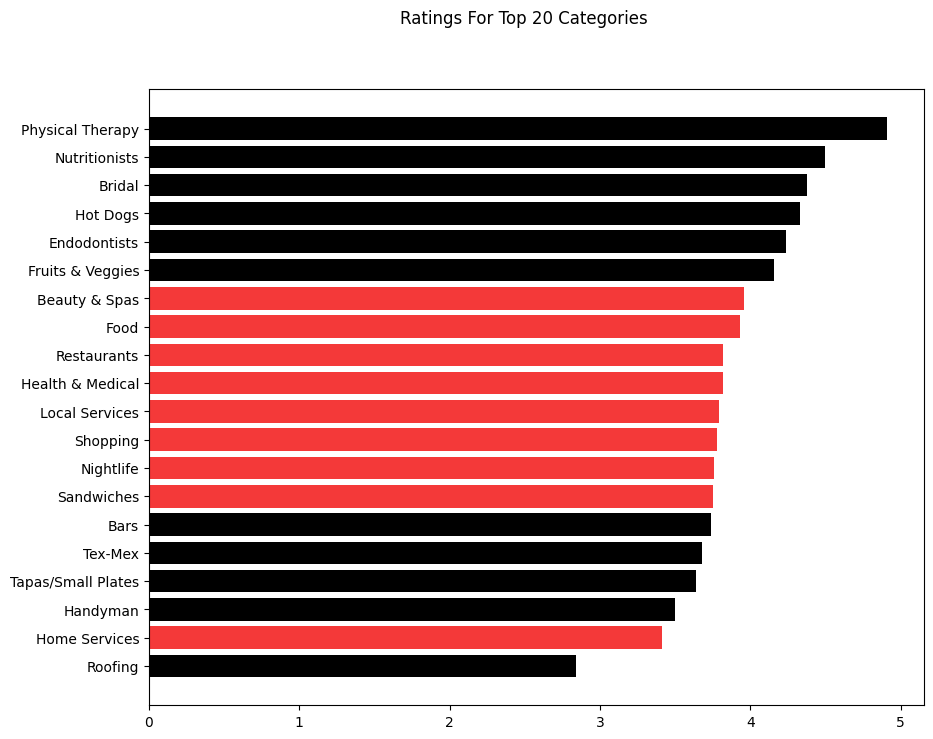

In [21]:
names = [d[0] for d in avgPerCat]
values = [d[1] for d in avgPerCat]
colors = ["#000000"] + ["#f43939"] + ["#000000"] * 4 + ["#f43939"] * 8 + ["#000000"] * 5

fig, ax = plt.subplots()
ax.barh(names, values, color=colors)
fig.suptitle('Ratings For Top 20 Categories')
fig.set_figheight(8)
fig.set_figwidth(10)
fig.show()

In [17]:
attr = {}
for d in newBusiness:
    if d['attributes']:
        ats = d['attributes'].keys()
        for a in ats:
            if a not in attr:
                attr[a] = 1
            else:
                attr[a] += 1

In [18]:
sortedDict = sorted(attr.items(), key=lambda x:x[1])
sortedDict.reverse()
sortedDict

[('BusinessAcceptsCreditCards', 12007),
 ('BusinessParking', 9500),
 ('RestaurantsPriceRange2', 8896),
 ('BikeParking', 7233),
 ('RestaurantsTakeOut', 6466),
 ('RestaurantsDelivery', 6149),
 ('WiFi', 5784),
 ('GoodForKids', 5770),
 ('OutdoorSeating', 5478),
 ('RestaurantsReservations', 5021),
 ('RestaurantsGoodForGroups', 4966),
 ('Alcohol', 4958),
 ('HasTV', 4908),
 ('Ambience', 4833),
 ('RestaurantsAttire', 4370),
 ('Caters', 4269),
 ('NoiseLevel', 4215),
 ('ByAppointmentOnly', 3738),
 ('GoodForMeal', 3042),
 ('WheelchairAccessible', 2709),
 ('RestaurantsTableService', 2068),
 ('BusinessAcceptsBitcoin', 1837),
 ('DogsAllowed', 1726),
 ('HappyHour', 1670),
 ('Music', 842),
 ('BestNights', 649),
 ('Corkage', 561),
 ('CoatCheck', 543),
 ('GoodForDancing', 531),
 ('DriveThru', 507),
 ('BYOBCorkage', 502),
 ('Smoking', 501),
 ('BYOB', 478),
 ('AcceptsInsurance', 449),
 ('HairSpecializesIn', 122),
 ('AgesAllowed', 21),
 ('Open24Hours', 8),
 ('RestaurantsCounterService', 2),
 ('DietaryRestr

In [24]:
at = 'BusinessAcceptsCreditCards'
options = set()
for d in newBusiness:
    if d['attributes']:
        ats = d['attributes'].keys()
        if at in ats:
            options.add(d['attributes'][at])

options

{'False', 'None', 'True'}

In [26]:
goodAt = ['BusinessAcceptsCreditCards', 'RestaurantsTakeOut', 'RestaurantsDelivery', 'GoodForKids', 'OutdoorSeating', 'RestaurantsReservations', 'RestaurantsGoodForGroups', 'HasTV']

avgPerAt = {}
for d in goodAt:
    avgPerAt[d] = [0,0,0,0,0,0]
    
for d in newBusiness:
    keys = avgPerAt.keys()
    
    words = []
    if d['attributes']:
        words = d['attributes'].keys()
    
    inter = list(set(keys).intersection(words))
    
    for i in inter:
        if d['attributes'][i] == 'True':
            avgPerAt[i][0] += d['stars']
            avgPerAt[i][1] += 1
        elif d['attributes'][i] == 'False':
            avgPerAt[i][2] += d['stars']
            avgPerAt[i][3] += 1
        else:
            avgPerAt[i][4] += d['stars']
            avgPerAt[i][5] += 1

In [27]:
for a in avgPerAt:
    avgPerAt[a] = [avgPerAt[a][0] / avgPerAt[a][1], avgPerAt[a][2] / avgPerAt[a][3], avgPerAt[a][4] / avgPerAt[a][5]]

Text(0.5, 0.98, 'Categorical Plotting')

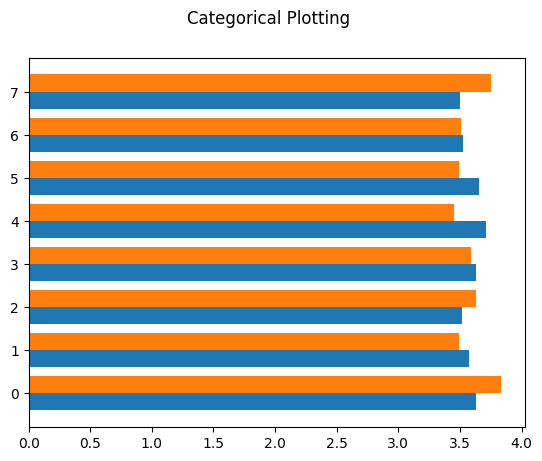

In [28]:
names = list(avgPerAt.keys())
values = list(avgPerAt.values())
v1 = [d[0] for d in values]
v2 = [d[1] for d in values]
v3 = [d[2] for d in values]
hg = 0.4
x = np.arange(8) 

fig, ax = plt.subplots()
ax.barh(x-0.2, v1, height = hg)
ax.barh(x+0.2, v2, height = hg)
#ax.barh(x+0.2, v3, height = hg)
fig.suptitle('Categorical Plotting')

BAG OF WORDS

In [11]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [12]:
reviewsTrain = reviews[:80000]
reviewsValid = reviews[80000:90000]
reviewsTest = reviews[90000:]

In [13]:
len(reviewsTrain),len(reviewsValid),len(reviewsTest)

(80000, 10000, 10000)

In [18]:
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    s = random.randint(0, 100)
    l = random.choice([0, 50])
    return "hsl(0, " + str(s) + "%, " + str(l) + "%)"

In [19]:
#Words
wordData = [d['text'] for d in reviewsTrain]
cloudWords = ' '
stopWords = set(STOPWORDS) 

mask = np.array(Image.open("yelpBlack2.png"))

for r in wordData:
    cloudWords += r

In [20]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', 
                mask=mask, stopwords = stopWords, margin = 10).generate(cloudWords)

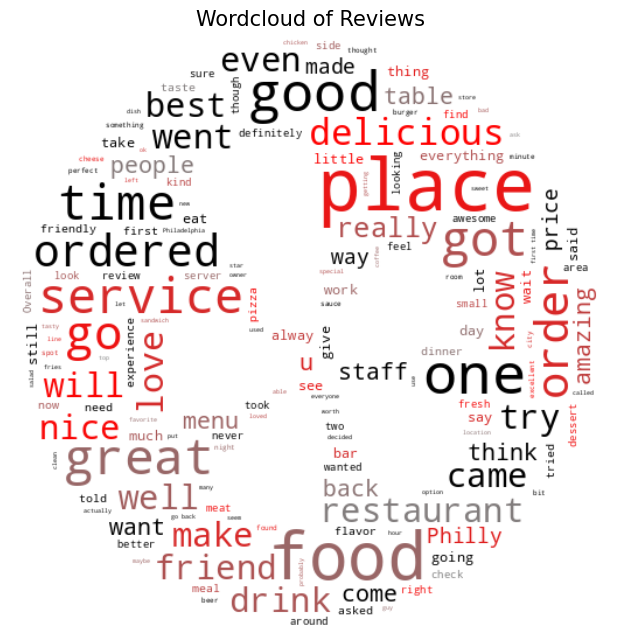

In [21]:
plt.figure(figsize = (6, 6)) 
plt.imshow(wordcloud.recolor(color_func=red_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.title('Wordcloud of Reviews', fontdict = {'fontsize' : 15})
plt.show()

In [ ]:
# UNIQUE WORDS
wordCount = defaultdict(int)
for d in wordData:
    for w in d.split():
        wordCount[w] += 1

len(wordCount)

In [14]:
# UNIQUE WORDS WITHOUT PUNCTUATION
wordData = [d['text'] for d in reviewsTrain]
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in wordData:
    r = ''.join([c for c in d.lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

len(wordCount)

97414

In [ ]:
# UNIQUE WORDS WITH STEMMING
wordCountStem = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = PorterStemmer()
for d in wordData:
    r = ''.join([c for c in d.lower() if not c in punctuation])
    for w in r.split():
        w = stemmer.stem(w)
        wordCountStem[w] += 1
    
len(wordCountStem)

In [ ]:
'''countStems = [(wordCountStem[w], w) for w in wordCountStem]
countStems.sort()
countStems.reverse()
wordStem = [x[1] for x in countStems[:2000]]
wordStem'''

In [15]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [16]:
words = [x[1] for x in counts[:500]]
len(words)

500

In [17]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [ ]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['text'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

In [ ]:
X = [feature(d) for d in reviewsTrain]
y = [d['stars'] for d in reviewsTrain]

In [ ]:
clf = linear_model.Ridge(1, fit_intercept=False)
clf.fit(X, y)
theta = clf.coef_

xValid = [feature(d) for d in reviewsValid]
yValid = [d['stars'] for d in reviewsValid]
predictions = clf.predict(xValid)

In [ ]:
MSE(yValid,predictions)

N-grams

In [ ]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in wordData:
    r = ''.join([c for c in d.lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
    ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
    ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
    for w in ws + ws2 + ws3 + ws4 + ws5:
        wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [ ]:
words = [x[1] for x in counts[:1000]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [ ]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['text'].lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
    ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
    ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
    for w in ws + ws2 + ws3 + ws4 + ws5:
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    return feat

In [ ]:
X = [feature(d) for d in reviewsTrain]
y = [d['stars'] for d in reviewsTrain]

In [ ]:
clf = linear_model.Ridge(1.0, fit_intercept=False)
clf.fit(X, y)
theta = clf.coef_

xValid = [feature(d) for d in reviewsValid]
yValid = [d['stars'] for d in reviewsValid]
predictions = clf.predict(xValid)

In [ ]:
MSE(yValid,predictions)

In [ ]:
wordSort = list(zip(theta[:-1], words))
wordSort.sort()

TF-IDF

In [ ]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in wordData:
    r = ''.join([c for c in d.lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

In [ ]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [ ]:
words = [x[1] for x in counts[:1000]]

In [ ]:
df = defaultdict(int)
for d in wordData:
    r = ''.join([c for c in d.lower() if not c in punctuation])
    for w in set(r.split()):
        df[w] += 1

In [ ]:
rev = reviewsTrain[5]
rev

In [ ]:
tf = defaultdict(int)
r = ''.join([c for c in rev['text'].lower() if not c in punctuation])
for w in r.split():
    tf[w] = 1
    
tfidf = dict(zip(words,[tf[w] * math.log2(len(reviewsTrain) / df[w]) for w in words]))
tfidfQuery = [tf[w] * math.log2(len(reviewsTrain) / df[w]) for w in words]

In [ ]:
maxTf = [(tf[w],w) for w in words]
maxTf.sort(reverse=True)
maxTfIdf = [(tfidf[w],w) for w in words]
maxTfIdf.sort(reverse=True)

In [ ]:
maxTfIdf[:10]

In [ ]:
def Cosine(x1,x2):
    numer = 0
    norm1 = 0
    norm2 = 0
    for a1,a2 in zip(x1,x2):
        numer += a1*a2
        norm1 += a1**2
        norm2 += a2**2
    if norm1*norm2:
        return numer / math.sqrt(norm1*norm2)
    return 0

In [ ]:
similarities = []
for rev2 in reviewsTrain:
    tf = defaultdict(int)
    r = ''.join([c for c in rev2['text'].lower() if not c in punctuation])
    for w in r.split():
        tf[w] = 1
    tfidf2 = [tf[w] * math.log2(len(reviewsTrain) / df[w]) for w in words]
    similarities.append((Cosine(tfidfQuery, tfidf2), rev2['text']))

In [ ]:
similarities.sort(reverse=True)

In [ ]:
similarities[-10:]

MODELING

In [18]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [19]:
reviewsTrain = reviews[:80000]
reviewsValid = reviews[80000:90000]
reviewsTest = reviews[90000:]

In [20]:
dist = [d['stars'] for d in reviewsTrain]
mean = statistics.mean(dist)
median = statistics.median(dist)

In [21]:
dataPerUser = defaultdict(set)
for d in users:
    u = d['user_id']
    dataPerUser[u] = d
    
dataPerBusiness = defaultdict(set)
for d in business:
    b = d['business_id']
    dataPerBusiness[b] = d

In [22]:
categories = {}
for d in business:
    if d['categories']:
        ws = d['categories'].split(',') 
        for w in ws:
            sw = w.strip()
            if sw not in categories:
                categories[sw] = 1
            else:
                categories[sw] += 1

sortedDict = sorted(categories.items(), key=lambda x:x[1])
sortedDict.reverse()

topCategories = [d[0] for d in sortedDict]

In [23]:
topCat = topCategories[:100]
catId = dict(zip(topCat, range(len(topCat))))

In [31]:
# Train BASELINE
b1 = [mean] * len(reviewsTrain)
b2 = [median] * len(reviewsTrain)
y = [d['stars'] for d in reviewsTrain]

mseB1 = MSE(b1, y)
mseB2 = MSE(b2, y)
mseB1, mseB2

(1.9270014693734436, 1.971175)

In [32]:
# Validation BASELINE
b1 = [mean] * len(reviewsValid)
b2 = [median] * len(reviewsValid)
y = [d['stars'] for d in reviewsValid]

mseB1 = MSE(b1, y)
mseB2 = MSE(b2, y)
mseB1, mseB2

(1.9389421556250335, 1.9925)

In [97]:
# TEST BASELINE
b1 = [mean] * len(reviewsTest)
b2 = [median] * len(reviewsTest)
y = [d['stars'] for d in reviewsTest]

mseB1 = MSE(b1, y)
mseB2 = MSE(b2, y)
mseB1, mseB2

(1.9084977756250245, 1.9481)

In [24]:
def feature(data):
    userID = data['user_id']
    busiID = data['business_id']
    
    userData = dataPerUser[userID]
    busiData = dataPerBusiness[busiID]
    
    ws = []
    for b in busiData:
        if busiData['categories']:
            ws = busiData['categories'].split(',') 
    
    f = [0]*len(topCat)
    for c in ws:
        if c in catId:
            f[catId[c]] += 1
            
    #business features
    f.append(busiData['longitude']) #100
    f.append(busiData['latitude']) #101
    f.append(busiData['stars']) #102
    f.append(busiData['review_count']) #103
    
    #user features
    f.append(userData['review_count']) #104
    f.append(userData['useful']) #105
    f.append(len(userData['friends'])) #106
    f.append(userData['average_stars']) #107
    f.append(userData['fans']) #108
    f.append(len(userData['elite'].split(','))) #109
    
    #review features
    f.append(data['useful']) #110
    f.append(len(data['text'])) #111
    
    #112 - 1111
    for i in range(len(words)):
        f.append(0)
    
    r = ''.join([c for c in data['text'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            f[wordId[w]+112] += 1
            
    #offest 1112
    f.append(1)
    
    return f

In [27]:
x = [feature(d) for d in reviewsTest]
len(x[0])

613

In [25]:
x = [feature(d) for d in reviewsTrain]
y = [d['stars'] for d in reviewsTrain]

validX = [feature(d) for d in reviewsValid]
validY = [d['stars'] for d in reviewsValid]

testX = [feature(d) for d in reviewsTest]
testY = [d['stars'] for d in reviewsTest]
len(x[0]) #2113

KeyboardInterrupt: 

In [92]:
#Linear

reg = linear_model.LinearRegression()
reg.fit(x, y)
    
trainYp = reg.predict(x)
mse = MSE(y, trainYp)

testYp = reg.predict(testX)
tMSE = MSE(testY, testYp)

print("MSE: " + str(mse))
print("TMSE: " + str(tMSE))

MSE: 0.7705498907917058
TMSE: 0.7753985292983603


In [93]:
#Ridge

reg = linear_model.Ridge()
reg.fit(x, y)

trainYp = reg.predict(x)
mse = MSE(y, trainYp)

testYp = reg.predict(testX)
tMSE = MSE(testY, testYp)

print("MSE: " + str(mse))
print("TMSE: " + str(tMSE))

MSE: 0.770550058649525
TMSE: 0.7753802026276331


In [96]:
#Random Forest

clf = RandomForestRegressor()
clf.fit(x, y)

trainYp = clf.predict(x)
mse = MSE(y, trainYp)

testYp = clf.predict(testX)
tMSE = MSE(testY, testYp)

print("MSE: " + str(mse))
print("TMSE: " + str(tMSE))

MSE: 0.10597943552604415
TMSE: 0.7522403861916717


In [113]:
trainMSE = [1.9270014693734436, 1.971175, 0.7705498907917058, 0.770550058649525, 0.10597943552604415]
testMSE = [1.9084977756250245, 1.9481, 0.7753985292983603, 0.7753802026276331, 0.7522403861916717]
label = ["Baseline 1", "Baseline 2", "Linear", "Ridge", "Random Forest"]

trainMSE = trainMSE[::-1]
testMSE = testMSE[::-1]
label = label[::-1]

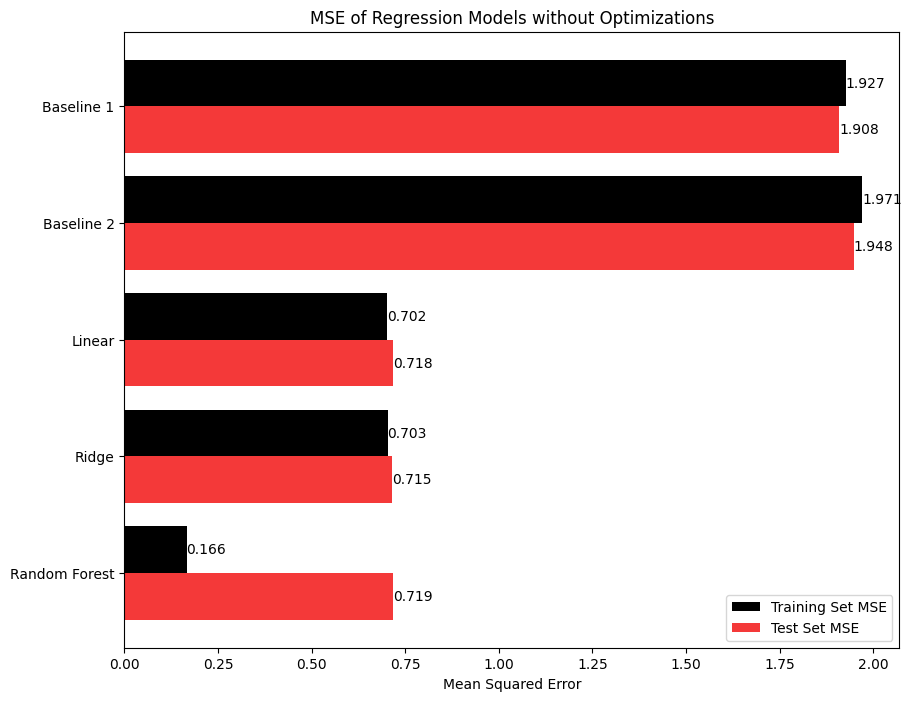

In [193]:
hg = 0.4
y_pos = np.arange(5) 

fig, ax = plt.subplots()
trainB = ax.barh(y_pos+0.2, trainMSE, height = hg, color='#000000', label="Training Set MSE")
testB = ax.barh(y_pos-0.2, testMSE, height = hg, color='#f43939', label="Test Set MSE")
ax.set_yticks(y_pos, labels=label)
ax.set_xlabel('Mean Squared Error')
ax.set_title('MSE of Regression Models without Optimizations')
ax.legend()
ax.bar_label(trainB, fmt='%.3f')
ax.bar_label(testB, fmt='%.3f')
fig.set_figheight(8)
fig.set_figwidth(10)
fig.show()

In [ ]:
# OPTIMIZED

In [89]:
# UNIQUE WORDS WITHOUT PUNCTUATION
wordData = [d['text'] for d in reviewsTrain]
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in wordData:
    r = ''.join([c for c in d.lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

words = [x[1] for x in counts[:1000]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [101]:
x = [feature(d) for d in reviewsTrain]
y = [d['stars'] for d in reviewsTrain]

validX = [feature(d) for d in reviewsValid]
validY = [d['stars'] for d in reviewsValid]

testX = [feature(d) for d in reviewsTest]
testY = [d['stars'] for d in reviewsTest]
len(x[0])

1113

In [183]:
#Linear

reg = linear_model.LinearRegression()
reg.fit(x, y)
    
trainYp = reg.predict(x)
mse = MSE(y, trainYp)

testYp = reg.predict(testX)
tMSE = MSE(testY, testYp)

print("MSE: " + str(mse))
print("TMSE: " + str(tMSE))

MSE: 0.7017344235483793
TMSE: 0.7177118598062088


In [ ]:
#Ridge

for c in [300]:
    reg = linear_model.Ridge(c)
    reg.fit(x, y)

    trainYp = reg.predict(x)
    mse = MSE(y, trainYp)
      
    validYp = reg.predict(validX)
    vMSE = MSE(validY, validYp)
    print("MSE: " + str(mse))
    print("VMSE: " + str(vMSE))

#VMSE: 0.7175184602426528

In [186]:
testYp = reg.predict(testX)
tMSE = MSE(testY, testYp)
print("TMSE: " + str(tMSE))
#TMSE: 0.7150637682625314

TMSE: 0.7150637682625314


In [30]:
#Random Forest
bestVMSE = 9999
keepMSE = 0
keepN = 0
keepDepth = 0

for n in [150]:
    for depth in [30]:
        clf = RandomForestRegressor(n_estimators=n, max_depth=depth, n_jobs=-1)
        clf.fit(x, y)

        trainYp = clf.predict(x)
        mse = MSE(y, trainYp)

        validYp = clf.predict(validX)
        vMSE = MSE(validY, validYp)
        print("MSE: " + str(mse))
        print("VMSE: " + str(vMSE))
        
        if vMSE < bestVMSE:
            bestVMSE = vMSE
            keepMSE = mse
            keepN = n
            keepDepth = depth
        

#MSE: 0.1063661088026462
#VMSE: 0.7787981527639944

MSE: 0.09842280044742835
VMSE: 0.7378948810618077


In [31]:
testYp = clf.predict(testX)
tMSE = MSE(testY, testYp)
print("TMSE: " + str(tMSE))
#TMSE: 0.7136583263152736

TMSE: 0.7166888210222221


In [56]:
trainMSE = [1.9084977756250245, 1.9481, 0.7753985292983603, 0.7753802026276331, 0.7522403861916717]
testMSE = [1.9084977756250245, 1.9481, 0.7177118598062088, 0.7150637682625314, 0.7136583263152736]
label = ["Baseline 1", "Baseline 2", "Linear", "Ridge", "Random Forest"]

trainMSE = trainMSE[::-1]
testMSE = testMSE[::-1]
label = label[::-1]

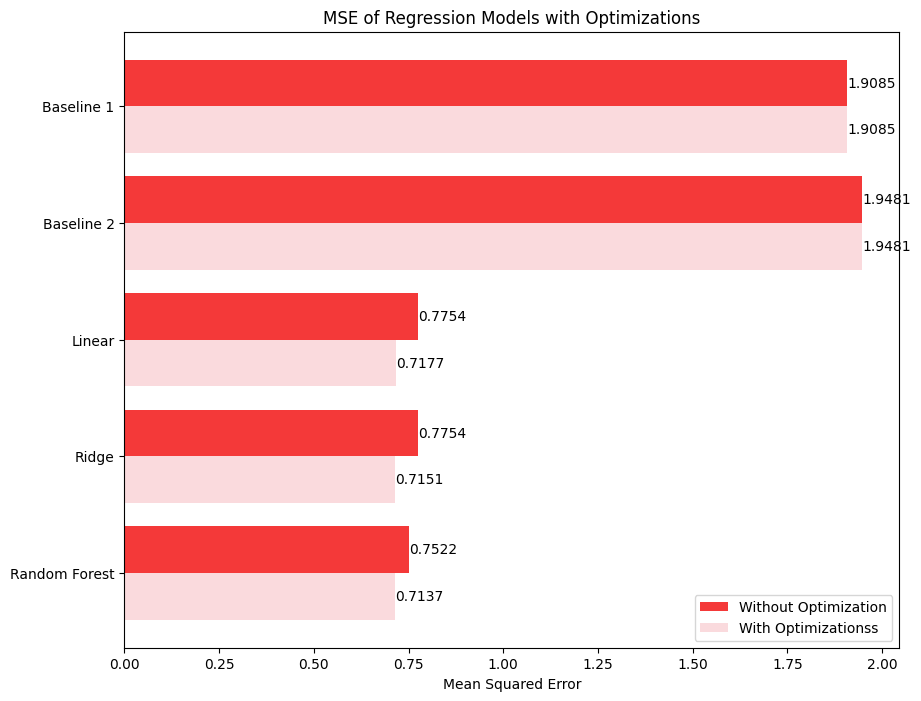

In [58]:
hg = 0.4
y_pos = np.arange(5) 

fig, ax = plt.subplots()
trainB = ax.barh(y_pos+0.2, trainMSE, height = hg, color='#f43939', label="Without Optimization")
testB = ax.barh(y_pos-0.2, testMSE, height = hg, color='#fadadd', label="With Optimizationss")
ax.set_yticks(y_pos, labels=label)
ax.set_xlabel('Mean Squared Error')
ax.set_title('MSE of Regression Models with Optimizations')
ax.legend()
ax.bar_label(trainB, fmt='%.4f')
ax.bar_label(testB, fmt='%.4f')
fig.set_figheight(8)
fig.set_figwidth(10)
fig.show()

In [ ]:
def feature(data):
    userID = data['user_id']
    busiID = data['business_id']
    
    userData = dataPerUser[userID]
    busiData = dataPerBusiness[busiID]
    
    ws = []
    for b in busiData:
        if busiData['categories']:
            ws = busiData['categories'].split(',') 
    
    f = [0]*len(topCat)
    for c in ws:
        if c in catId:
            f[catId[c]] += 1
            
    #business features
    f.append(busiData['longitude']) #100
    f.append(busiData['latitude']) #101
    f.append(busiData['stars']) #102
    f.append(busiData['review_count']) #103
    
    #user features
    f.append(userData['review_count']) #104
    f.append(userData['useful']) #105
    f.append(len(userData['friends'])) #106
    f.append(userData['average_stars']) #107
    f.append(userData['fans']) #108
    f.append(len(userData['elite'].split(','))) #109
    
    #review features
    f.append(data['useful']) #110
    f.append(len(data['text'])) #111
    
    #112 - 1111
    for i in range(len(words)):
        f.append(0)
    
    r = ''.join([c for c in data['text'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            f[wordId[w]+112] += 1
            
    #offest 1112
    f.append(1)
    
    return f

In [69]:
np.argsort(clf.feature_importances_)[-10:], np.sort(clf.feature_importances_)[-10:]

(array([103, 105, 126, 200, 111, 104, 144, 132, 102, 107]),
 array([0.00945927, 0.00949419, 0.00988474, 0.01062143, 0.01136906,
        0.0120647 , 0.01877521, 0.03439207, 0.14297326, 0.28824557]))

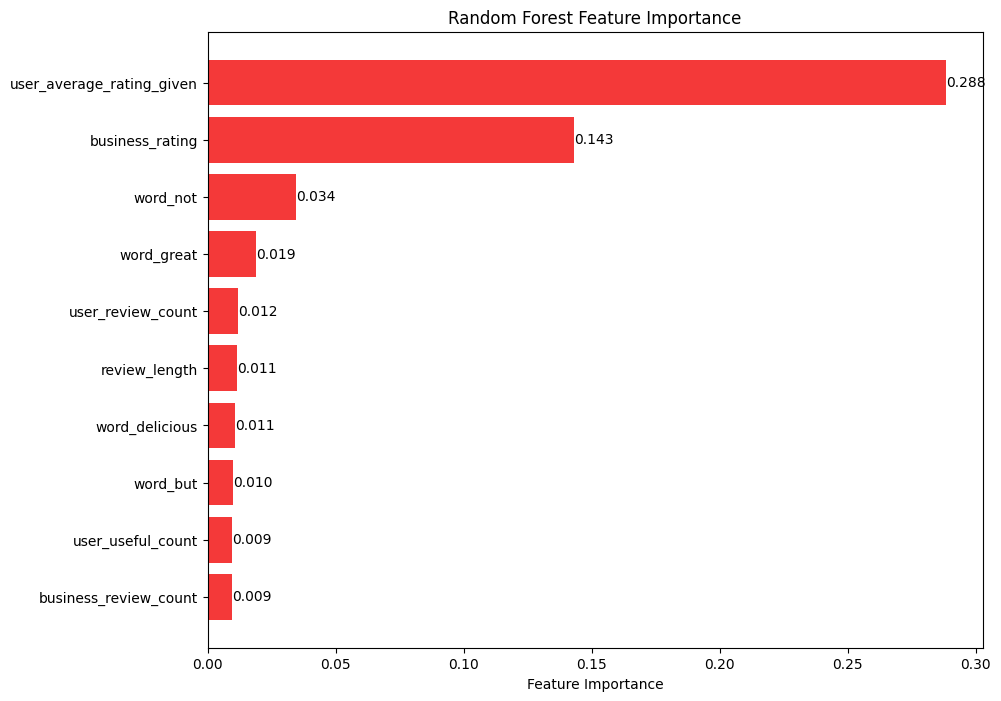

In [81]:
x = np.sort(clf.feature_importances_)[-10:]
label = ["business_review_count", "user_useful_count","word_but","word_delicious","review_length","user_review_count","word_great","word_not","business_rating","user_average_rating_given"]
y_pos = np.arange(10) 

fig, ax = plt.subplots()
barH = ax.barh(y_pos, x, color='#f43939')
ax.set_yticks(y_pos, labels=label)
ax.set_xlabel('Feature Importance')
ax.set_title('Random Forest Feature Importance')
ax.bar_label(barH, fmt='%.3f')
fig.set_figheight(8)
fig.set_figwidth(10)
fig.show()

In [103]:
np.argsort(clf.feature_importances_)[:11], np.sort(clf.feature_importances_)[:11]

(array([1112,   45,   95,   96,   80,   78,   91,   88,   53,   50,   30]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        3.51797916e-06, 4.90827690e-06, 6.59771562e-06, 7.54858232e-06,
        9.60262818e-06, 1.21068511e-05, 1.25919085e-05]))

In [104]:
worst = ["Wine & Spirits","Music & Video","Mags","Accessories","General Dentistry","Trainers","Home Decor","Education","Women's Clothing", "Home & Garden"]
worst

['Wine & Spirits',
 'Music & Video',
 'Mags',
 'Accessories',
 'General Dentistry',
 'Trainers',
 'Home Decor',
 'Education',
 "Women's Clothing",
 'Home & Garden']